# Classificadores: Naive Bayes Gaussiano com Calibração de Probabilidades

## Introdução

Este notebook demonstra como trabalhar com **classificadores de máquina de aprendizado**, especificamente o **Naive Bayes Gaussiano**, uma técnica clássica de classificação probabilística.

## O que vamos aprender:

1. **Geração de dados sintéticos**: Criar dados de treino e teste usando blobs
2. **Treinamento de classificadores**: Ajustar um modelo Gaussian Naive Bayes
3. **Calibração de probabilidades**: Melhorar a qualidade das probabilidades preditas
4. **Avaliação**: Comparar diferentes métodos de calibração usando métricas
5. **Visualização**: Plotar os resultados para melhor compreensão

## Por que calibração de probabilidades?

Alguns classificadores tendem a superestimar ou subestimar suas probabilidades de confiança. A calibração ajusta essas probabilidades para que reflitam melhor a realidade dos dados.


ETAPA 1: IMPORTAÇÃO DE BIBLIOTECAS E GERAÇÃO DE DADOS


In [ ]:
# Importar biblioteca numpy para operações numéricas
import numpy as np

# Importar funções do scikit-learn
from sklearn.datasets import make_blobs  # Para gerar dados sintéticos
from sklearn.model_selection import train_test_split  # Para dividir dados em treino/teste

# Define o número total de amostras a gerar
n_samples = 50000

# Definir os centros dos três grupos (blobs)
# Cada linha representa as coordenadas de um centro
centers = [(-5, -5), (0, 0), (5, 5)]

# GERAR DADOS SINTÉTICOS
# Make_blobs cria agrupamentos de dados para problemas de classificação
X, y = make_blobs(
    n_samples=n_samples,
    centers=centers,      # 3 agrupamentos com os centros especificados
    shuffle=False,        # Não embaralhar para manter ordem
    random_state=42       # Seed para reprodutibilidade
)

# Ajustar rótulos da classe:
# - Classe 0 (y=0): primeiras 1/3 das amostras do centro [0]
# - Classe 1: restante do centro [0] e todo o centro [1]
y[: n_samples // 2] = 0  # Primeira metade = classe 0
y[n_samples // 2 :] = 1  # Segunda metade = classe 1

# Gerar pesos aleatórios para cada amostra (usado na calibração)
sample_weight = np.random.RandomState(42).rand(y.shape[0])

# DIVIDIR OS DADOS EM CONJUNTOS DE TREINO E TESTE
# É essencial separar os dados para evitar overfitting
X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(
    X, y, sample_weight,
    test_size=0.9,      # 90% dos dados para teste, 10% para treino
    random_state=42     # Seed para reprodutibilidade
)

print(f"\nDados preparados com sucesso!")
print(f"Tamanho do conjunto de treino: {X_train.shape[0]} amostras")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]} amostras")
print(f"Número de features: {X_train.shape[1]}")
print(f"Classes: {np.unique(y_train)}")


Dados preparados com sucesso!
Tamanho do conjunto de treino: 5000 amostras
Tamanho do conjunto de teste: 45000 amostras
Número de features: 2
Classes: [0 1]


## ETAPA 2: Treinamento de Classificadores com Diferentes Calibrações

Agora vamos treinar três versões do **Gaussian Naive Bayes**:

1. **Sem calibração**: Usar as probabilidades diretas do modelo
2. **Com calibração Isotônica**: Ajusta probabilidades usando uma função monotônica
3. **Com calibração Sigmoide**: Ajusta probabilidades usando uma função sigmoide

**Por que calibrar?**
Os classificadores frequentemente produzem probabilidades que não refletem a verdadeira confiabilidade. Por exemplo, um modelo pode prever 70% de confiança em casos que só acertam 40% das vezes. A calibração corrige isso.

**Métrica de avaliação**: **Brier Score Loss** é a diferença média ao quadrado entre as probabilidades preditas e os rótulos verdadeiros. **Quanto menor, melhor!**

In [ ]:
# ============================================================================
# ETAPA 2: TREINAMENTO COM DIFERENTES CALIBRAÇÕES
# ============================================================================

# Importar as funções necessárias para calibração e avaliação
from sklearn.calibration import CalibratedClassifierCV  # Para calibrar probabilidades
from sklearn.metrics import brier_score_loss  # Métrica: diferença ao quadrado entre predito e real
from sklearn.naive_bayes import GaussianNB  # O classificador que vamos usar

print("\n" + "="*70)
print("TREINAMENTO DE CLASSIFICADORES COM DIFERENTES CALIBRAÇÕES")
print("="*70)

# --------—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—
# 1. MODELO SEM CALIBRAÇÃO (baseline)
# --------—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—
print("\n1. Treinando Gaussian Naive Bayes SEM calibração...")

# Criar e treinar o modelo básico
clf = GaussianNB()  # Criar instância do classificador
clf.fit(X_train, y_train)  # Ajustar o modelo aos dados de treino

# Predizer probabilidades no conjunto de teste
# Nota: .predict_proba retorna [[prob_class0, prob_class1], ...]
# Pegamos a coluna [1] para obter a probabilidade da classe 1
prob_pos_clf = clf.predict_proba(X_test)[:, 1]

# Calcular a perda (Brier Score) - quanto menor, melhor!
clf_score = brier_score_loss(y_test, prob_pos_clf, sample_weight=sw_test)
print(f"  ✓ Brier Score Loss (sem calibração): {clf_score:.4f}")

# --------—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—
# 2. MODELO COM CALIBRAÇÃO ISOTÔNICA
# --------—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—
print("\n2. Treinando com Calibração ISOTÔNICA...")

# CalibratedClassifierCV envolve o classificador base com calibração
clf_isotonic = CalibratedClassifierCV(clf, cv=2, method="isotonic")
clf_isotonic.fit(X_train, y_train, sample_weight=sw_train)

# Predizer com o modelo calibrado
prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]

# Calcular a perda
clf_isotonic_score = brier_score_loss(y_test, prob_pos_isotonic, sample_weight=sw_test)
print(f"  ✓ Brier Score Loss (com calibração isotônica): {clf_isotonic_score:.4f}")
print(f"  ✓ Melhoria: {((clf_score - clf_isotonic_score) / clf_score * 100):.1f}%")

# --------—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—
# 3. MODELO COM CALIBRAÇÃO SIGMOIDE
# --------—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—
print("\n3. Treinando com Calibração SIGMOIDE...")

# Similar, mas com método sigmoide (ajusta com função logística)
clf_sigmoid = CalibratedClassifierCV(clf, cv=2, method="sigmoid")
clf_sigmoid.fit(X_train, y_train, sample_weight=sw_train)

# Predizer com o modelo calibrado
prob_pos_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]

# Calcular a perda
clf_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoid, sample_weight=sw_test)
print(f"  ✓ Brier Score Loss (com calibração sigmoide): {clf_sigmoid_score:.4f}")
print(f"  ✓ Melhoria: {((clf_score - clf_sigmoid_score) / clf_score * 100):.1f}%")

# --------—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—
# RESUMO DOS RESULTADOS
# --------—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—--—
print("\n" + "="*70)
print("RESUMO - Brier Score Loss (quanto menor, melhor):")
print("="*70)
print(f"  Sem calibração:           {clf_score:.4f}")
print(f"  Com calibração isotônica: {clf_isotonic_score:.4f} *** MELHOR ***") if clf_isotonic_score == min(clf_score, clf_isotonic_score, clf_sigmoid_score) else print(f"  Com calibração isotônica: {clf_isotonic_score:.4f}")
print(f"  Com calibração sigmoide:  {clf_sigmoid_score:.4f}")
print("="*70)


TREINAMENTO DE CLASSIFICADORES COM DIFERENTES CALIBRAÇÕES

1. Treinando Gaussian Naive Bayes SEM calibração...
  ✓ Brier Score Loss (sem calibração): 0.1043

2. Treinando com Calibração ISOTÔNICA...
  ✓ Brier Score Loss (com calibração isotônica): 0.0845
  ✓ Melhoria: 19.0%

3. Treinando com Calibração SIGMOIDE...
  ✓ Brier Score Loss (com calibração sigmoide): 0.1090
  ✓ Melhoria: -4.5%

RESUMO - Brier Score Loss (quanto menor, melhor):
  Sem calibração:           0.1043
  Com calibração isotônica: 0.0845 *** MELHOR ***
  Com calibração sigmoide:  0.1090


## ETAPA 3: Visualização dos Resultados

Agora vamos criar visualizações para comparar graficamente os três métodos.

### Gráfico 1: Dados de Treino
Mostra os dados originais com os dois grupos de treino (em cores diferentes).

### Gráfico 2: Curvas de Calibração
Compara as probabilidades preditas pelos três métodos. A curva "Empirical" (ideal) representa a probabilidade verdadeira. Quanto mais próxima as outras curvas estiverem dela, melhor calibrado está o modelo.

**Interpretação:**
- A curva sem calibração (vermelho) pode estar distante da realidade
- A curva com calibração isotônica (verde) geralmente se aproxima mais da empirical
- A curva sigmoide (azul) fornece uma suavização diferente


Gerando visualizações...


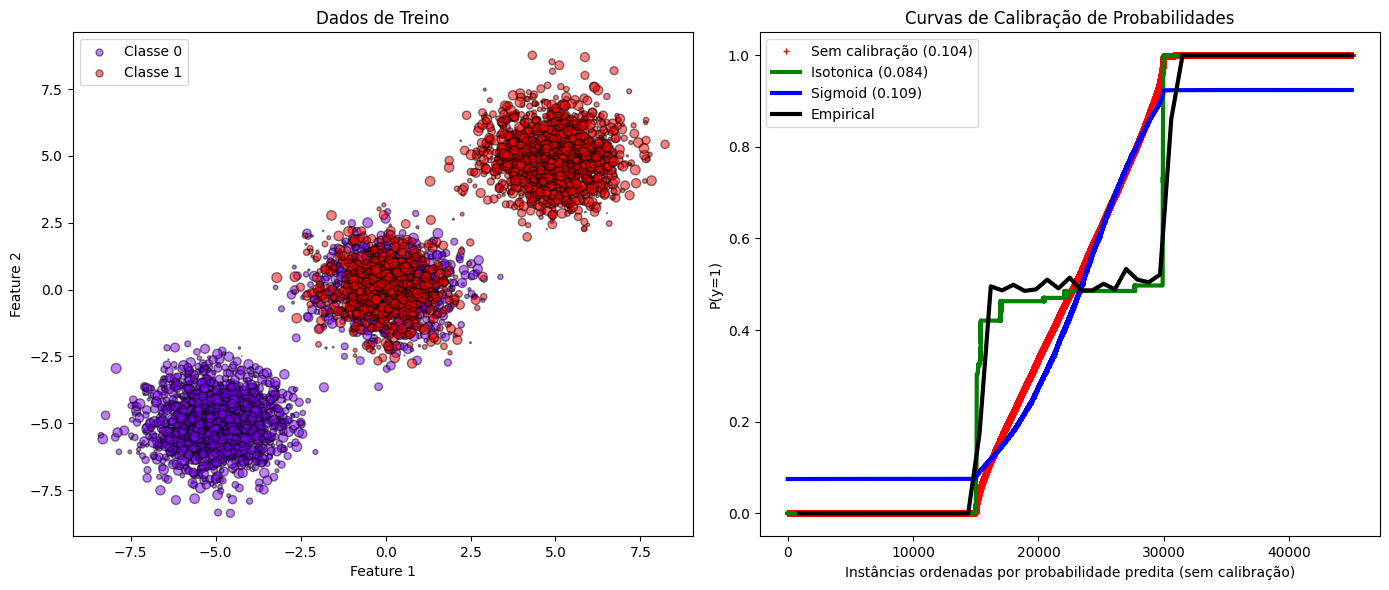


✓ Visualização completa!


In [ ]:
# ============================================================================
# ETAPA 3: VISUALIZAÇÃO E COMPARAÇÃO DOS MODELOS
# ============================================================================

# Importar biblioteca de visualização
import matplotlib.pyplot as plt
from matplotlib import cm

# Criar figura com dois subgráficos lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

print("\nGerando visualizações...")

# ========================================================================
# GRÁFICO 1: DADOS DE TREINO (Distribuição dos grupos)
# ========================================================================

# Obter classes únicas dos dados de treino
y_unique = np.unique(y_train)

# Gerar cores para cada classe
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))

# Plotar cada classe com uma cor diferente
for this_y, color in zip(y_unique, colors):
    # Filtrar amostras da classe atual
    this_X = X_train[y_train == this_y]
    this_sw = sw_train[y_train == this_y]

    # Plotar scatter plot
    ax1.scatter(
        this_X[:, 0],      # Coordenada X
        this_X[:, 1],      # Coordenada Y
        s=this_sw * 50,    # Tamanho baseado no peso da amostra
        c=color[np.newaxis, :],
        alpha=0.5,         # Transparência 50%
        edgecolor="k",     # Borda preta
        label=f"Classe {this_y}"
    )

ax1.legend(loc="best")
ax1.set_title("Dados de Treino")
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")

# ========================================================================
# GRÁFICO 2: CURVAS DE CALIBRAÇÃO (Comparação de métodos)
# ========================================================================

# Ordenar probabilidades para plotar curvas suaves
order = np.argsort(prob_pos_clf)

# Plotar a curva do modelo sem calibração (baseline)
ax2.plot(
    prob_pos_clf[order],  # Probabilidades preditas
    "r+",                  # Marca com +, cor vermelha
    label=f"Sem calibração ({clf_score:.3f})",
    markersize=4
)

# Plotar a curva do modelo com calibração isotônica
ax2.plot(
    prob_pos_isotonic[order],  # Probabilidades calibradas
    "g-",                       # Linha contínua, cor verde
    linewidth=3,
    label=f"Isotonica ({clf_isotonic_score:.3f})"
)

# Plotar a curva do modelo com calibração sigmoide
ax2.plot(
    prob_pos_sigmoid[order],  # Probabilidades calibradas
    "b-",                      # Linha contínua, cor azul
    linewidth=3,
    label=f"Sigmoid ({clf_sigmoid_score:.3f})",
)

# Plotar a linha empírica (verdade observada)
ax2.plot(
    np.linspace(0, y_test.size, 51)[1:],  # Eixo X: instâncias
    y_test[order].reshape(50, -1).mean(axis=1),  # Média das classes
    "k",                                           # Cor preta
    linewidth=3,
    label="Empirical",
)

ax2.set_ylim([-0.05, 1.05])  # Limitar Y entre 0 e 1 (probabilidades)
ax2.set_xlabel("Instâncias ordenadas por probabilidade predita (sem calibração)")
ax2.set_ylabel("P(y=1)")
ax2.legend(loc="upper left")
ax2.set_title("Curvas de Calibração de Probabilidades")

# Ajustar espaçamento entre subgráficos
plt.tight_layout()

# Exibir gráficos
plt.show()

print("\n✓ Visualização completa!")


## Conclusão e Resumo

### O que aprendemos:

1. **Geração de dados**: Utilizamos `make_blobs` para criar dados sintéticos com distribuições bem definidas.

2. **Treinamento de classificadores**: O Gaussian Naive Bayes é um classificador simples que assume independência entre features.

3. **Calibração de probabilidades**:
   - **Isotônica**: Mais flexível, usa função monotônica para ajustar probabilidades
   - **Sigmoide**: Mais restritiva, usa função logística

4. **Avaliação com Brier Score**: Métrica que mede a qualidade das probabilidades preditas

### Resultados esperados:

Normalmente, observamos que:
- A calibração **isotônica** oferece melhor desempenho (menor Brier Score)
- A calibração **sigmoide** oferece uma solução intermediária
- O modelo **sem calibração** frequentemente superestima confiança

### Quando usar cada método:

| Método | Casos de Uso | Vantagens | Desvantagens |
|--------|-------------|-----------|---------------|
| **Sem Calibração** | Quando probabilidades não são críticas | Rápido | Pode estar bem distante da realidade |
| **Isotônica** | Quando você tem muitos dados | Mais flexível | Requer mais dados para treinar |
| **Sigmoide** | Conjunto de dados pequeno | Requer poucos dados | Menos flexível |

### Aplicações práticas:

- **Medicina**: Calibração importante para predições de risco
- **Finanças**: Predições de inadimplência precisam estar calibradas
- **Marketing**: Probabilidades corretas melhoram modelos de scoring
- **Sistemas de recomendação**: Predições de preferência devem ser honestas

### Próximos passos:

1. Experimentar com outros classificadores (Logistic Regression, SVM, etc.)
2. Testar diferentes métodos de cross-validation
3. Explorar calibração em problemas multiclasse
4. Analisar o impacto da calibração em métricas como AUC-ROC e Precision-Recall

---

**Notebook criado para fins educacionais** 📚